# Prophet 

PV output is a stochastic variable influenced both by predictable factors such clear sky irradiance (which can be perfectly determined by the solar panel's latitude, longitude, altitude, and the time) as well as by cloud cover and other weather and environmental conditions which can only be forecast with error.  Due to these factors PV output has seasonal, trend, and random components. 

The purpose of the larger project is to design and price solar output insurance contracts in ways that might lead to more widespread adoption and lower premiums.  There is an existing small market for solar parametric insurance, for example contracts that offer to make payouts when a solar irradiance index falls below a certain level.  But these contracts leave the panel operator with considerable basis risk (i.e. exposed to considerable risk).   The goal of this project is to explore and parameteric insurance that is based on a measure of PV output that would be much more highly correlated with the panel operator's revenue.  

The idea is to use a model to decompose the stochastic characteristics of PV output in order to understand its stochastic properties better.  Amongst other things PV output may display trend and seasonal components and the remaining risk may not have constant variance through time.  Considerable time-series analysis goes into discovering these properties to build a model that can help price insurance contracts in different settings and in different prospective scenarios.

Methods such as [SARIMAX](SARIMAX.ipynb) use differencing and autocorrelations to identify and model seasonality as a recurring dependence on past values at fixed intervals, requiring manual specification search for the best seasonal orders and careful parameter tuning.  Prophet instead employs Bayesian methods and Fourier series decomposition methods to fit seasonal trends, allowing the model to determine the complexity based on the data and allowing for smoother seasonal shapes. This Bayesian approach in Prophet also allows one to quantify uncertainty, leading to more possibly more informative and robust forecasts (somewhat similar quantification can be done with SARIMAX via block bootstrapping methods, but many of these methods are built into prophet).

In [1]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_yearly
import matplotlib.pyplot as plt
import seaborn as sns
import pvlib
from sklearn.metrics import mean_absolute_error, root_mean_squared_error  

## Solar PV Output Data

See some [sata and visual analysis](pv_visual.ipynb) of the PV output data.  Twenty four years of daily PV output for Fresno California.

In [4]:
file_path = "./data/daily_output.CSV"
df = pd.read_csv(file_path)
df['0'] = df['0'].astype('float32')
df.index = pd.to_datetime(df['datetime'])
df.rename(columns={ '0': 'y', 'datetime':'ds'}, inplace=True)
df['y'] = df['y'].where(df['y'] >= 0, 0)
print(df.y.describe().round(1))

count    9131.0
mean     2686.5
std       935.3
min         0.0
25%      2355.5
50%      3089.3
75%      3321.3
max      3912.2
Name: y, dtype: float64


In [4]:
df.drop(columns=['day_of_year', 'month'], inplace=True)


,ds,y
datetime,,
1998-01-01,1998-01-01,1735.571289
1998-01-02,1998-01-02,636.379150
1998-01-03,1998-01-03,2811.400879
1998-01-04,1998-01-04,1079.356079
1998-01-05,1998-01-05,2243.751221


## Prophet modeling

The prophet package is a time series forecasting package that is easy to use and can handle trend and seasonal components.  We will use it to decompose the time series into trend, seasonal, and random components.  We will then use the residuals to estimate the distribution of the random component.

In [27]:
model = Prophet(
    yearly_seasonality='auto',# Automatically detect yearly seasonality
    daily_seasonality=False,   # Suppress daily seasonality
    weekly_seasonality=False,  # Suppress weekly seasonality
    holidays=None,             # Suppress holidays
    changepoint_prior_scale=0.05,
)

model.fit(df)

yearly_order = model.seasonalities['yearly']['fourier_order']
print(f"Yearly Fourier order: {yearly_order}")


19:07:02 - cmdstanpy - INFO - Chain [1] start processing
19:07:03 - cmdstanpy - INFO - Chain [1] done processing


Yearly Fourier order: 10


In [28]:
df.head()

,ds,y,ghi
datetime,,,
1998-01-01,1998-01-01,1735.571289,0.000003
1998-01-02,1998-01-02,636.379150,0.000003
1998-01-03,1998-01-03,2811.400879,0.000003
1998-01-04,1998-01-04,1079.356079,0.000003
1998-01-05,1998-01-05,2243.751221,0.000003


C:\Users\jonat\AppData\Local\Temp\ipykernel_62756\839630981.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


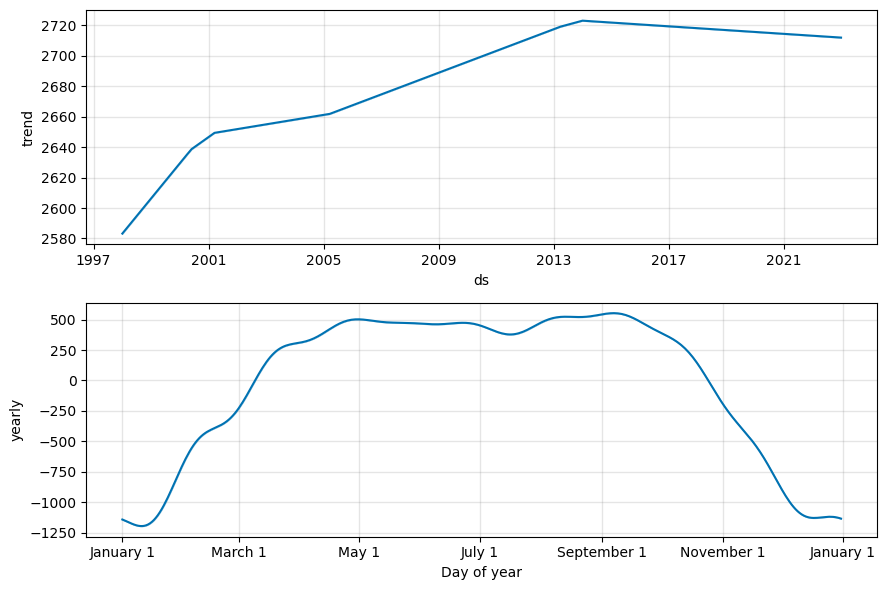

In [29]:
future = model.make_future_dataframe(periods=0)  # No future periods needed for component plots
forecast = model.predict(future)

# Plot the components
fig = Prophet.plot_components(model, forecast)
fig.show()

In [32]:
rmse_baseline = root_mean_squared_error(df['y'], forecast['yhat'])  # No need for squared=False
mae_baseline = mean_absolute_error(df['y'], forecast['yhat'])

print("Baseline Model:")
print(f"  RMSE: {rmse_baseline:.2f}")
print(f"  MAE: {mae_baseline:.2f}")


Baseline Model:
  RMSE: 717.91
  MAE: 519.07


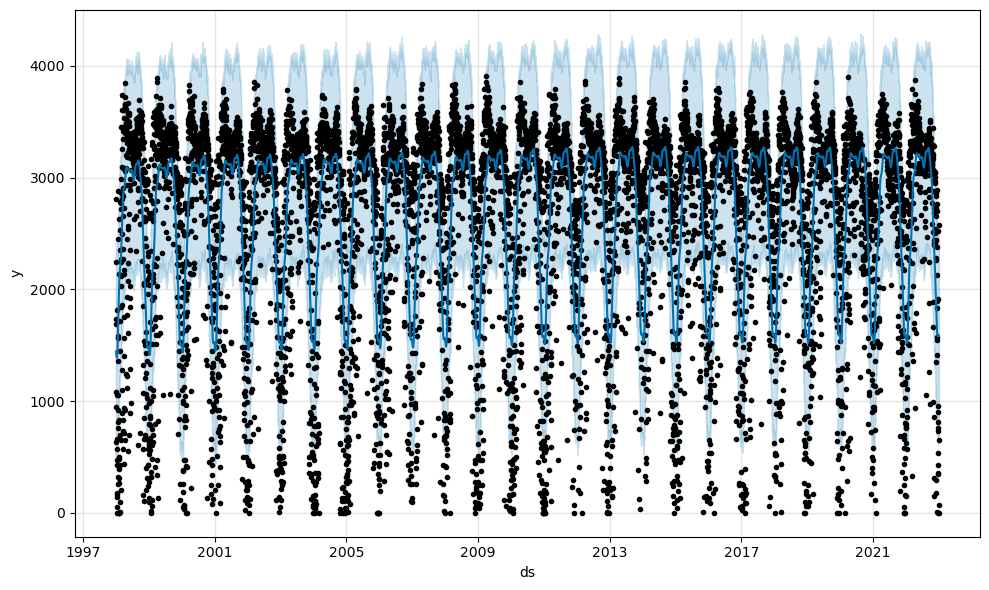

In [40]:
# Plot the fit
fig = model.plot(forecast);


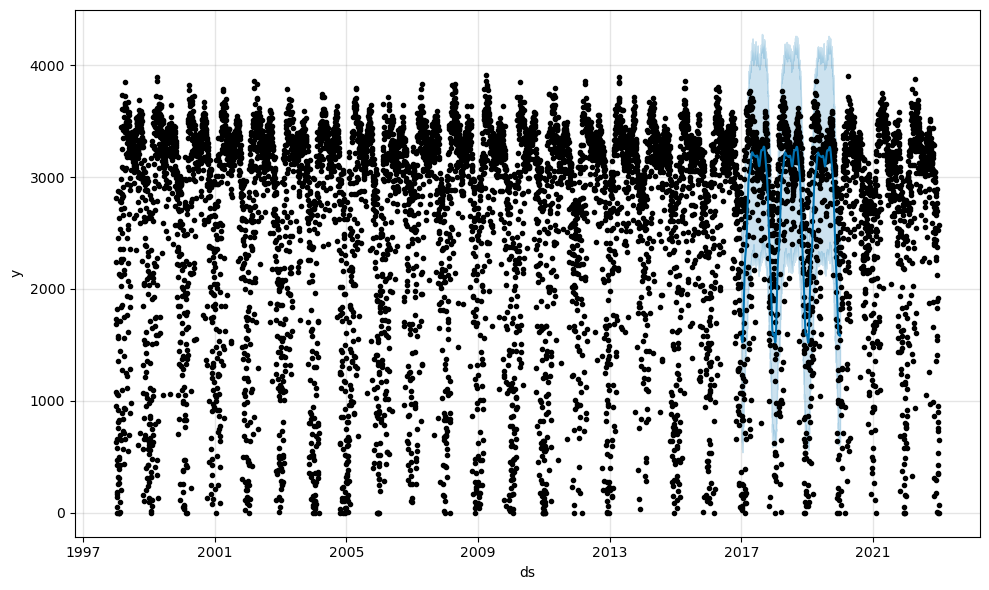

In [42]:
forecast_filtered = forecast[(forecast['ds'] >= '2017-01-01') & (forecast['ds'] <= '2019-12-31')]
fig = model.plot(forecast_filtered)
plt.show()


In [465]:

# Calculate RMSE using root_mean_squared_error
rmse_baseline = root_mean_squared_error(df['y'], forecast_baseline['yhat'])  # No need for squared=False
rmse_with_ghi = root_mean_squared_error(df['y'], forecast_with_ghi['yhat'])

mae_baseline = mean_absolute_error(df['y'], forecast_baseline['yhat'])
mae_with_ghi = mean_absolute_error(df['y'], forecast_with_ghi['yhat'])

# ... (similarly for MAPE -  no change needed for MAPE) ...

In [466]:
print("Baseline Model:")
print(f"  RMSE: {rmse_baseline:.2f}")
print(f"  MAE: {mae_baseline:.2f}")

print("\nModel with GHI:")
print(f"  RMSE: {rmse_with_ghi:.2f}")
print(f"  MAE: {mae_with_ghi:.2f}")

# Compare the metrics
print("\nComparison:")
if rmse_with_ghi < rmse_baseline:
    print(f"  RMSE improved by {rmse_baseline - rmse_with_ghi:.2f}")
else:
    print(f"  RMSE worsened by {rmse_with_ghi - rmse_baseline:.2f}")

if mae_with_ghi < mae_baseline:
    print(f"  MAE improved by {mae_baseline - mae_with_ghi:.2f}")
else:
    print(f"  MAE worsened by {mae_with_ghi - mae_baseline:.2f}")

# ... (similar comparison for MAPE if you calculated it) ...

Baseline Model:
  RMSE: 7910.31
  MAE: 5783.94

Model with GHI:
  RMSE: 8079.56
  MAE: 6012.41

Comparison:
  RMSE worsened by 169.25
  MAE worsened by 228.47


This very tiny improvement shows that the Fourier picked up essentially everything.

In [467]:
# Display model parameters
#print(model.params)

# Display component modes
#print(model.component_modes)

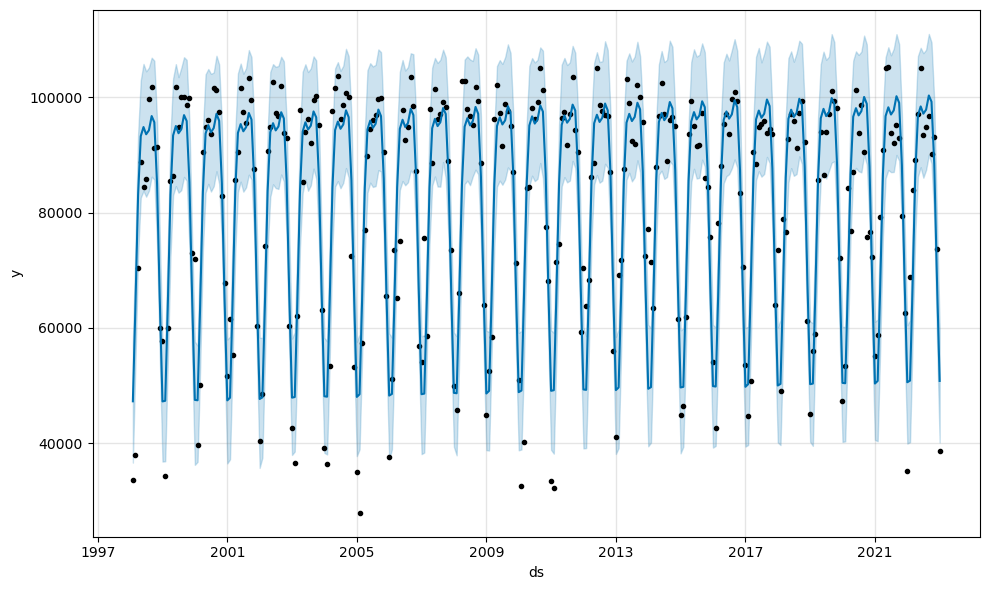

In [468]:
# Predict on the historical data
historical_forecast = model.predict(df)

# Plot the fit
fig = model.plot(historical_forecast)

plt.show()

#TODO:  
  - need to add ghi to future dataframe.   
  - how does adding the ghi affect the fit... it looks the same, suggesting picked up anyway.



In [469]:

# Make a future dataframe for predictions
future = model.make_future_dataframe(periods=365)

# Predict the future
forecast = model.predict(future)

# Display the forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,1998-01-31,47296.581915,36317.447517,56916.074361
1,1998-02-28,63177.757955,52657.677114,73624.038045
2,1998-03-31,83038.400682,72421.715855,93314.161482
3,1998-04-30,93225.949238,83156.036536,104401.238958
4,1998-05-31,94803.335230,84759.231344,105046.717596


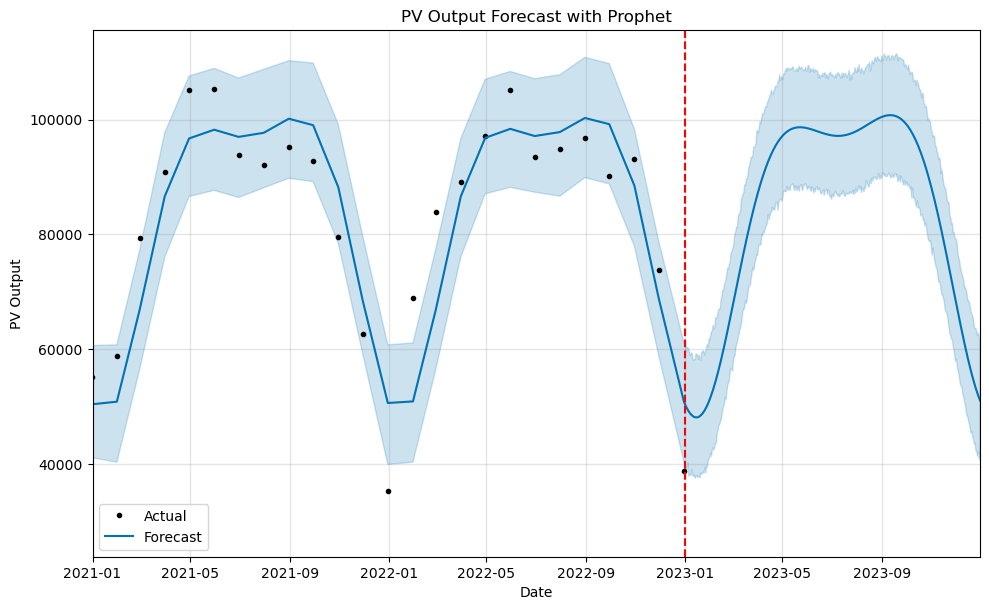

In [491]:
fig1 = model.plot(forecast)
plt.title('PV Output Forecast with Prophet')
plt.xlabel('Date')
plt.ylabel('PV Output')
plt.legend(['Actual', 'Forecast'])  # Add this line for the legend
plt.xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2023-12-31'))
plt.axvline(pd.Timestamp('2023-01-01'), color='red', linestyle='--', label='2023-01-01')  # Add vertical line
plt.show()



### Cross validation

Cross-validation is a technique for evaluating the performance of a predictive model by testing it on data that wasn't used during training. This helps you:

- Estimate Real-World Performance: It gives you a more realistic idea of how your model will perform on new, unseen data. This is crucial because a model that overfits the training data may not generalize well to future observations.
- Tune Hyperparameters: You can use cross-validation to compare different model configurations (e.g., different values for Prophet's changepoint_prior_scale parameter) and select the one that performs best.
- Identify Potential Issues: Cross-validation can reveal problems like overfitting or biases in your model that might not be apparent from just looking at the training data.

Prophet's cross_validation function simulates how your model would have performed in the past. Here's the basic process:

1. Cutoff Points: It splits your historical data into multiple training and testing sets by choosing different cutoff points in time.
2. Training and Forecasting: For each cutoff point, it trains the model on the data before the cutoff and then makes forecasts for the data after the cutoff.
3. Performance Evaluation: It compares the forecasts to the actual values in the testing sets to calculate error metrics (e.g., mean absolute error, root mean squared error).

In [471]:
df_cv = cross_validation(model, initial=pd.Timedelta(days=10*365.25), period='30 days', horizon = '365 days', parallel="processes")

In [472]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2008-02-29,61652.255365,52022.464991,71652.828479,66137.687500,2008-02-13
1,2008-03-31,84131.936845,74873.389749,94081.829144,102806.937500,2008-02-13
2,2008-04-30,93869.546795,84415.980700,102952.555582,102717.601562,2008-02-13
3,2008-05-31,96083.435471,85567.559025,106203.633940,97982.210938,2008-02-13
4,2008-06-30,97318.606542,87631.049166,107692.172027,96637.757812,2008-02-13


In [473]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
print(df_p['mse'].mean())
df_p['mae'].mean()
df_p['mdape'].mean()

71867427.47109999


0.05955280506338167

c:\Users\jonat\miniforge3\Lib\site-packages\prophet\plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\jonat\miniforge3\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


(5000.0, 7000.0)

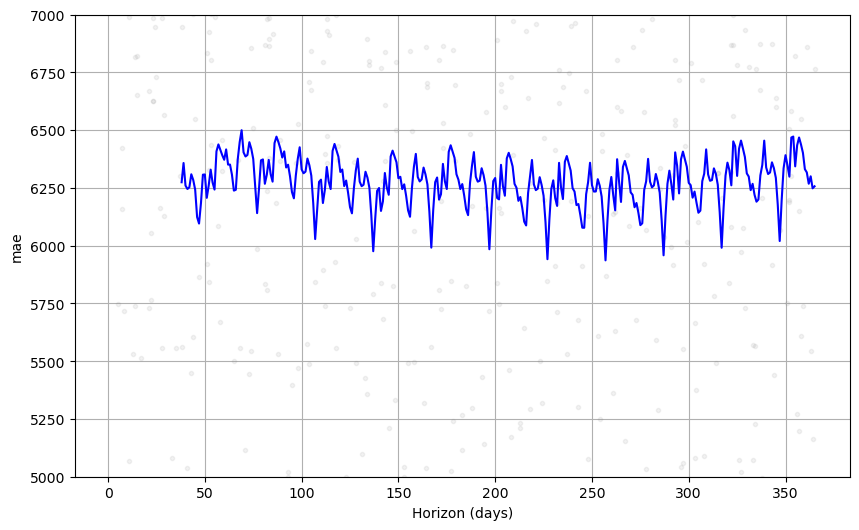

In [487]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')
plt.ylim(5000, 7000)

In [475]:
future = model.make_future_dataframe(periods=365)  # For 1 year of future predictions

In [476]:
forecast_samples = model.predict(future)


In [208]:
import numpy as np
lower_bound = np.percentile(forecast_samples[:, :, forecast_samples.columns.get_loc('yhat')], 2.5, axis=1)  # 2.5th percentile
upper_bound = np.percentile(forecast_samples[:, :, forecast_samples.columns.get_loc('yhat')], 97.5, axis=1)  # 97.5th percentile




InvalidIndexError: (slice(None, None, None), slice(None, None, None), 15)

In [209]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(forecast_samples.shape[1]):  # Loop through samples
    plt.plot(future['ds'], forecast_samples[:, i, forecast_samples.columns.get_loc('yhat')], color='lightgray', alpha=0.5)

plt.plot(future['ds'], forecast['yhat'], color='blue', label='Mean Forecast')  # Plot the mean forecast
plt.fill_between(future['ds'], lower_bound, upper_bound, color='blue', alpha=0.2, label='95% Prediction Interval')
plt.xlabel('Date')
plt.ylabel('PV Output')
plt.legend()
plt.show()

InvalidIndexError: (slice(None, None, None), 0, 15)

<Figure size 1000x600 with 0 Axes>

In [ ]:
import prophet
print(prophet.__version__)
print("")